In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
# !unzip -u "/content/adlmr.zip" -d "/content/drive/MyDrive/dataDL"

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import random


folder_path = '/content/drive/MyDrive/dataDL/adlmr' # Path to dataset

data = []  # List to store the data
colnames  = ['Date', 'Time', 'SensorID', 'Value', 'ResidentID1', 'TaskID1','ResidentID2', 'TaskID2','ResidentID3', 'TaskID3']

# Iterate through files in the folder
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)  # Get the full path of the file
    if os.path.isfile(file_path):  # Check if it's a file (not a directory)
        df = pd.read_csv(file_path, delimiter=r"\s+", lineterminator='\r', names=colnames)
        data.append(df)

# Concatenate all DataFrames into a single DataFrame
combined_df = pd.concat(data, ignore_index=True)

In [ ]:
"""la description de la base de données indique qu'on peut avoir plusieurs personnes entrain de faire une tache en meme temps,
une valeur aberrante se produit lorsque 3 personnes la font,
 nous choisirons de supprimer cette ligne car
 elle ajoute une complexite de calcul trop grande pour la probabilite qu'elle represente c-a-d: 1/17230
"""

combined_df[~combined_df['ResidentID3'].isna()]

,Date,Time,SensorID,Value,ResidentID1,TaskID1,ResidentID2,TaskID2,ResidentID3,TaskID3
16441,\n2008-11-12,14:59:41.115119,M14,ON,2,13.0,1.0,13.0,1.0,13.0


In [ ]:
# eliminer la ligne ou les valeurs ResidentID3 et TaskID3 existent

combined_df = combined_df[combined_df['ResidentID3'].isna()]

# maintent nous pouvons eliminer les columns ResidentID3 et TaskID3

columns_to_drop = ['ResidentID3', 'TaskID3']
combined_df.drop(columns_to_drop, axis=1, inplace=True)

In [ ]:
# Supprimer les caractères de saut de ligne ("\n") de la colonne 'Date'
combined_df.loc[:, 'Date'] = combined_df['Date'].apply(lambda x: x.replace('\n', ''))
#Convert the 'Time' column to datetime and crop microseconds
combined_df.loc[:,'Time'] = pd.to_datetime(combined_df['Time']+'00', format='%H:%M:%S.%f',errors='ignore')
# Convert the 'Time' column to datetime, setting invalid values to NaT
combined_df['Time'] = pd.to_datetime(combined_df['Time'], format='%H:%M:%S.%f', errors='coerce')
# Drop rows with NaN values in the 'Time' column
combined_df.dropna(subset=['Time'], inplace=True)
# Convert the 'Date' column to datetime, setting invalid values to NaT
combined_df['Date'] = pd.to_datetime(combined_df['Date'], format='%Y-%m-%d', errors='coerce')

# Drop rows with NaN values in the 'Time' column
combined_df.dropna(subset=['Date'], inplace=True)

# Join 'Date' and 'Time' columns into a new column 'DateTime' to gain compute time and reduce dimensionality
combined_df['DateTime'] = combined_df['Date'].dt.strftime('%Y-%m-%d') + ' ' + combined_df['Time'].dt.strftime('%H:%M:%S.%f')

# Drop the original 'Date' and 'Time' columns if desired
combined_df.drop(['Date', 'Time'], axis=1,inplace=True)

In [ ]:
# Define the list of values to filter because the only valid sensor ids according to description file of data are these:
sensor_ids = ['D13', 'D14', 'D15']

# Filter the DataFrame based on the 'SensorId' column values
combined_df = combined_df[~combined_df['SensorID'].isin(sensor_ids)]

In [ ]:
# transform to numerical values because certain values a string format
combined_df.loc[:,'ResidentID1'] = pd.to_numeric(combined_df['ResidentID1'], errors='coerce')
# Removing the incoherent value from the ResidentID1
combined_df = combined_df[~combined_df['ResidentID1'].isin([211])]
# removing rows where ResidentID1 is null
combined_df = combined_df[~combined_df['ResidentID1'].isna()]

<ipython-input-79-0c6e5b4e67e6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df.loc[:,'ResidentID1'] = pd.to_numeric(combined_df['ResidentID1'], errors='coerce')
<ipython-input-79-0c6e5b4e67e6>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  combined_df.loc[:,'ResidentID1'] = pd.to_numeric(combined_df['ResidentID1'], errors='coerce')


In [ ]:
combined_df.describe()

,ResidentID1,TaskID1,ResidentID2,TaskID2
count,17018.000000,17018.000000,2907.000000,2907.000000
mean,1.509226,8.191973,1.591675,11.986240
std,0.499930,4.382367,0.491608,2.884055
min,1.000000,1.000000,1.000000,1.000000
25%,1.000000,4.000000,1.000000,11.000000
50%,2.000000,8.000000,2.000000,13.000000
75%,2.000000,12.000000,2.000000,14.000000
max,2.000000,15.000000,2.000000,15.000000


In [ ]:
# taches faites par Person A: avec ResidentID = 1 selon la description:
person_a_tasks  = [1,3,5,7,8,10,11,12,13,15]
# taches faites par Person B: avec ResidentID = 2  selon la description:
person_b_tasks  = [2,3,4,6,7,9,11,13,14]

In [ ]:
# Create a mask for the conditions
mask = (
    (((combined_df['ResidentID1'] == 1) & ~combined_df['TaskID1'].isin(person_a_tasks)) &
    ((combined_df['ResidentID1'] == 2) & ~combined_df['TaskID1'].isin(person_b_tasks)))
    |
     (((combined_df['ResidentID2'] == 1) & ~combined_df['TaskID2'].isin(person_a_tasks)) &
    ((combined_df['ResidentID2'] == 2) & ~combined_df['TaskID2'].isin(person_b_tasks)))
)

# Replace values that do not match the conditions with null values
combined_df[['ResidentID1', 'TaskID1','ResidentID2', 'TaskID2']] = combined_df[['ResidentID1', 'TaskID1','ResidentID2', 'TaskID2']].mask(mask, np.nan)


In [ ]:
# Set ResidentID2 to null if TaskID2 is null and vice versa
combined_df.loc[combined_df['TaskID2'].isnull(), 'ResidentID2'] = np.nan
combined_df.loc[combined_df['ResidentID2'].isnull(), 'TaskID2'] = np.nan

# Set ResidentID1 to null if TaskID1 is null and vice versa
combined_df.loc[combined_df['TaskID1'].isnull(), 'ResidentID1'] = np.nan
combined_df.loc[combined_df['ResidentID1'].isnull(), 'TaskID1'] = np.nan

In [ ]:
combined_df = combined_df.dropna(subset=['ResidentID1', 'TaskID1', 'ResidentID2', 'TaskID2'], how='all')

In [ ]:
combined_df.head(5)

,SensorID,Value,ResidentID1,TaskID1,ResidentID2,TaskID2,DateTime
0,M02,ON,2.0,2.0,NaN,NaN,2008-12-10 14:26:52.207880
1,M05,ON,2.0,2.0,NaN,NaN,2008-12-10 14:26:52.690700
2,M02,OFF,2.0,2.0,NaN,NaN,2008-12-10 14:26:55.291239
3,M16,ON,1.0,1.0,NaN,NaN,2008-12-10 14:26:57.219990
4,M15,ON,1.0,1.0,NaN,NaN,2008-12-10 14:26:57.601710


In [ ]:
# Il semble y'avoir une erreur de saisie avec l'une des valeurs du sensor de type D qui doit etre 'OPEN' plutot que 'OPENv'
# correction :
combined_df.loc[combined_df['SensorID'].str.startswith('D'), 'Value'] = combined_df.loc[combined_df['SensorID'].str.startswith('D'), 'Value'].replace('OPENv', 'OPEN')
# Il semble y'avoir une erreur de saisie avec l'une des valeurs du sensor de type M qui doit etre 'OFF' plutot que 'OF'
# correction:
combined_df.loc[combined_df['SensorID'].str.startswith('M'), 'Value'] = combined_df.loc[combined_df['SensorID'].str.startswith('M'), 'Value'].replace('OF', 'OFF')

In [ ]:
# convert the DateTime column to datetime object
combined_df['DateTime'] = pd.to_datetime(combined_df['DateTime'])
# sort the values according to the time
combined_df.sort_values(by='DateTime', inplace = True)
# reset the index because of deleted values
combined_df.reset_index(drop=True,inplace=True)

<Axes: >

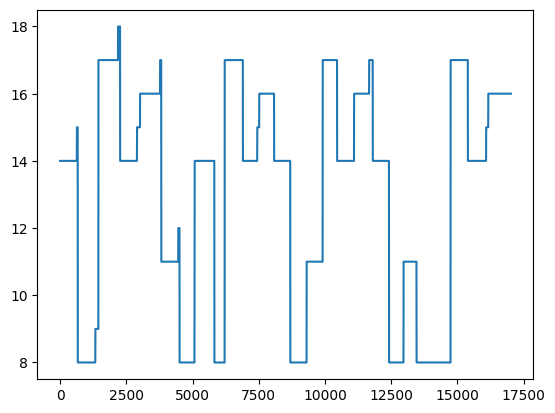

In [ ]:
# There's clearly a cyclic nature in the recodings of data, our goal is to capture this while encoding
combined_df.DateTime.dt.hour.plot()

In [ ]:
combined_df['DateTime'].dt.year.unique()

array([2008])

In [ ]:
# pas besoin de l'année vu que toutes les données sont de 2008
# encodage du temps ref https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/:
combined_df['day_sin'] = np.sin(2 * np.pi * combined_df['DateTime'].dt.dayofweek / 7)
combined_df['day_cos'] = np.cos(2 * np.pi * combined_df['DateTime'].dt.dayofweek / 7)
combined_df['hour_sin'] = np.sin(2 * np.pi * combined_df['DateTime'].dt.hour / 24)
combined_df['hour_cos'] = np.cos(2 * np.pi * combined_df['DateTime'].dt.hour / 24)
combined_df['minute_sin'] = np.sin(2 * np.pi * combined_df['DateTime'].dt.minute / 60)
combined_df['minute_cos'] = np.cos(2 * np.pi * combined_df['DateTime'].dt.minute / 60)
combined_df['second_sin'] = np.sin(2 * np.pi * combined_df['DateTime'].dt.second / 60)
combined_df['second_cos'] = np.cos(2 * np.pi * combined_df['DateTime'].dt.second / 60)
combined_df['microsecond_sin'] = np.sin(2 * np.pi * combined_df['DateTime'].dt.microsecond / 1000000)
combined_df['microsecond_cos'] = np.cos(2 * np.pi * combined_df['DateTime'].dt.microsecond / 1000000)

# Drop the original 'DateTime' column if desired
combined_df.drop('DateTime', axis=1, inplace=True)

In [ ]:
# encodage du sensorID

# Extract the sensor category and number
combined_df['SensorCategory'] = combined_df['SensorID'].str[0]
combined_df['SensorNumber'] = combined_df['SensorID'].str[1:].astype(int)

# One-hot encode the sensor category
category_encoded = pd.get_dummies(combined_df['SensorCategory'], prefix='SensorCategory')

# One-hot encode the sensor number
number_encoded = pd.get_dummies(combined_df['SensorNumber'].astype(str), prefix='SensorNumber')

# Concatenate the encoded columns with the original DataFrame
df_encoded = pd.concat([combined_df, category_encoded, number_encoded], axis=1)

# Remove the original columns
df_encoded = df_encoded.drop(columns=['SensorCategory', 'SensorNumber','SensorID'])


In [ ]:
# Convert NaN values in ResidentID2 to a specific identifier
df_encoded['ResidentID2'] = df_encoded['ResidentID2'].fillna('NaN')

# Concatenate the two ResidentID columns into a single column
df_encoded['CombinedResidentID'] = df_encoded['ResidentID1'].astype(str) + '_' + df_encoded['ResidentID2'].astype(str)

# One-hot encode the combined column
encoded_resident_ids = pd.get_dummies(df_encoded['CombinedResidentID'], prefix='ResidentID')

# Concatenate the encoded columns with the original DataFrame
df_encoded = pd.concat([df_encoded, encoded_resident_ids], axis=1)

# Remove the original columns
df_encoded = df_encoded.drop(columns=['ResidentID1', 'ResidentID2', 'CombinedResidentID'])

In [ ]:
# same process for taskIDs
# Convert NaN values in TaskID2 to a specific identifier
df_encoded['TaskID2'] = df_encoded['TaskID2'].fillna('NaN')

# Concatenate the two ResidentID columns into a single column
df_encoded['CombinedTaskID'] = df_encoded['TaskID1'].astype(str) + '_' + df_encoded['TaskID2'].astype(str)

# One-hot encode the combined column
encoded_task_ids = pd.get_dummies(df_encoded['CombinedTaskID'], prefix='TaskID')

# Concatenate the encoded columns with the original DataFrame
df_encoded = pd.concat([df_encoded, encoded_task_ids], axis=1)

# Remove the original columns
df_encoded = df_encoded.drop(columns=['TaskID1', 'TaskID2', 'CombinedTaskID'])

In [ ]:
# One-hot encode the value column
encoded_values = pd.get_dummies(df_encoded['Value'], prefix='Value')
# Concatenate the encoded columns with the original DataFrame
df_encoded = pd.concat([df_encoded, encoded_values], axis=1)
# Remove the original columns
df_encoded = df_encoded.drop(columns=['Value'])

In [ ]:
#drop the rows where ResidentID_1.0_1.0 and ResidentID_2.0_2.0 are 1 which is impossible in real life (same person doing two tasks at the same time)
df_encoded = df_encoded.drop((df_encoded[(df_encoded['ResidentID_1.0_1.0'] == 1) | (df_encoded['ResidentID_2.0_2.0'] == 1)]).index)

In [ ]:
# drop the columns where the column sum is 0 as results of the precedent droppings:
column_sums = df_encoded.sum()
zero_sum_columns = column_sums[column_sums == 0].index
df_encoded = df_encoded.drop(zero_sum_columns, axis=1)

In [ ]:
df_encoded.to_excel("données_filtrées.xlsx")

In [ ]:
target_columns = list(x for x in encoded_resident_ids.columns.append(encoded_task_ids.columns) if x in list(df_encoded.columns))
input_columns = [x for x in list(df_encoded.columns) if x not in target_columns]

In [ ]:
data_train, data_test = train_test_split(df_encoded, test_size=0.4,shuffle=False)
X_train, y_train = data_train[input_columns], data_train[target_columns]
X_test, y_test = data_test[input_columns], data_test[target_columns]

In [ ]:
from sklearn.metrics import recall_score
from sklearn.utils import check_random_state
# Set the seed value for Python's random number generator
seed = 42
random.seed(seed)

# Set the seed value for NumPy's random number generator
np.random.seed(seed)

# Set the seed value for PyTorch's random number generator
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set the seed value for Scikit-learn's random number generator
check_random_state(seed)


model_configs = [
    {'hidden_layers': [32]},
    {'hidden_layers': [64]},
    {'hidden_layers': [96]},
    {'hidden_layers': [128]}, c
    {'hidden_layers': [128, 256, 128]},
    {'hidden_layers': [96, 128, 96]},
    {'hidden_layers': [256, 256, 128, 64]},
    {'hidden_layers': [64,128, 256, 128,64]},
    {'hidden_layers': [512, 256, 128, 64]},
    {'hidden_layers': [512, 512, 256, 128, 64]},
    {'hidden_layers': [1024, 1024, 512, 128, 64]},
    {'hidden_layers': [128,512,1024, 1024,1024, 1024, 512, 128]},
    {'hidden_layers': [4096, 2048, 1024, 512, 128, 64]},
    {'hidden_layers': [4096, 4096, 2048, 2048, 512, 512,512,128]},
    {'hidden_layers': [128, 512, 2048, 4096, 2048,512,128]},
    {'hidden_layers': [64,128, 512, 2048, 4096, 2048,512,128,64]},
]

results = []  # To store the performance results for each model
f1_global = 0
for config in model_configs:
    # Define your DNN model
    class DNN(nn.Module):
        def __init__(self, input_shape,output_shape, hidden_layers):
            super(DNN, self).__init__()
            layers = []
            layers.append(nn.Linear(input_shape, hidden_layers[0]))
            layers.append(nn.ReLU())
            for i in range(len(hidden_layers) - 1):
                layers.append(nn.Linear(hidden_layers[i], hidden_layers[i + 1]))
                layers.append(nn.ReLU())
            layers.append(nn.Linear(hidden_layers[-1], output_shape))
            layers.append(nn.Sigmoid())
            self.model = nn.Sequential(*layers)

        def forward(self, x):
            return self.model(x)

    model = DNN(input_shape=len(input_columns),output_shape=len(target_columns), hidden_layers=config['hidden_layers'])
    model.to(torch.device("cuda"))

    # Convert the data to PyTorch tensors and move to the GPU
    X_train_torch = torch.tensor(X_train.values, dtype=torch.float32).to(torch.device("cuda"))
    y_train_torch = torch.tensor(y_train.values, dtype=torch.float32).to(torch.device("cuda"))
    X_test_torch = torch.tensor(X_test.values, dtype=torch.float32).to(torch.device("cuda"))
    y_test_torch = torch.tensor(y_test.values, dtype=torch.float32).to(torch.device("cuda"))

    # Define the loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    num_epochs = 500
    train_losses = []
    val_losses = []
    f1best = 0

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_torch)
        loss = criterion(outputs, y_train_torch)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            y_pred = model(X_test_torch)
            val_loss = criterion(y_pred, y_test_torch)
            val_losses.append(val_loss.item())
            y_pred_binary = torch.round(y_pred)
            accuracy = torch.mean((y_pred_binary == y_test_torch).float()).item()
            true_positives = torch.sum(y_pred_binary * y_test_torch).item()
            recall = recall_score(y_test, y_pred_binary.cpu().numpy(), average='micro')
            predicted_positives = torch.sum(y_pred_binary).item()
            precision = true_positives / predicted_positives if predicted_positives != 0 else 0.0
            f1 = f1_score(y_test, y_pred_binary.cpu().numpy(), average='micro')
            if f1> f1best:
                  f1best = f1
                  for result in results:
                         if result['config'] == config:
                           results.remove(result)
                  results.append({'config': config, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score': f1,'iteration':epoch})
            if f1> f1_global :
              f1_global = f1
              torch.save(model.state_dict(),'best_model_weights.pth')

    # Plot the training and validation loss over epochs
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Configuration: {}'.format(config))
    plt.legend()
    plt.show()

# Find the best model based on F1 score
best_model = max(results, key=lambda x: x['f1_score'])

# Print the performance results for each model
for result in results:
    print('Model Configuration:', result['config'])
    print('Accuracy:', result['accuracy'])
    print('Precision:', result['precision'])
    print('Recall:', result['recall'])
    print('F1 Score:', result['f1_score'])
    print('at iteration:', result['iteration'])
    print('-' * 50)

print('Best Model Configuration:', best_model['config'])
print('Best Accuracy:', best_model['accuracy'])
print('Best Precision:', best_model['precision'])
print('Best Recall:', best_model['recall'])
print('Best F1 Score:', best_model['f1_score'])
print('at iteration:', best_model['iteration'])